In [ ]:
import tensorflow as tf
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Epoch 1/400
640/640 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0023
Epoch 2/400
640/640 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0024
Epoch 3/400
640/640 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0026
Epoch 4/400
640/640 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0022
Epoch 5/400
640/640 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0023
Epoch 6/400
640/640 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0023
Epoch 7/400
640/640 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0021
Epoch 8/400
640/640 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0023
Epoch 9/400
640/640 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0020
Epoch 10/400
640/640 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0019
Epoch 11/400
640/640 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0022
Epoch 12/400
640/640 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0021
Epoch 13/400
640/640 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0022
Epoch 14/400
640/640 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0019
Epoch 15/400
640/640 ━━━━━━━━━━━━━━━━━━━━ 

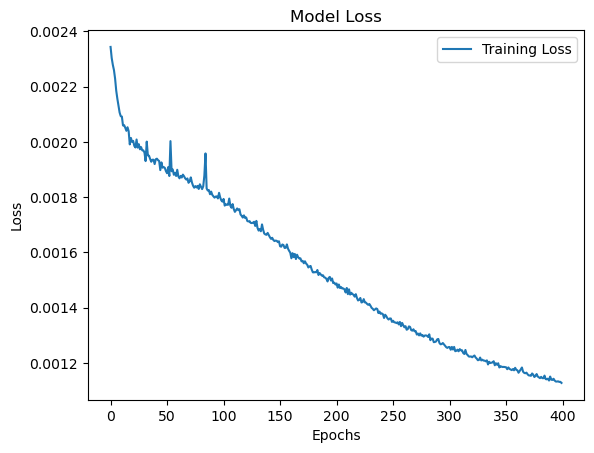

640/640 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0012
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step


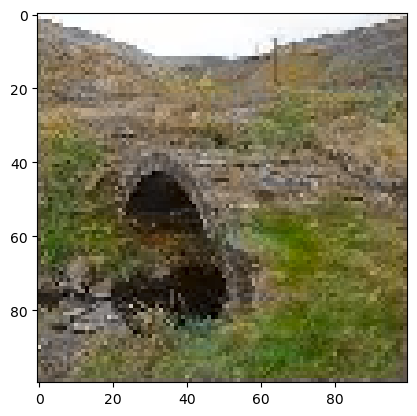

In [1]:
import numpy as np
from IPython.display import display, Image
from matplotlib.pyplot import imshow
from keras.layers import Conv2D, UpSampling2D, InputLayer, Layer
from keras.models import Sequential
from keras.preprocessing.image import img_to_array, load_img
from skimage.color import lab2rgb, rgb2lab
from skimage import color
import keras as keras
import tensorflow as tf
import glob
import cv2 as cv2
import os
import matplotlib.pyplot as plt

# Data loading and preprocessing
folder_path = './Data/Black_White/'
images1 = []
for img in os.listdir(folder_path):
    img = folder_path + img
    img = load_img(img, target_size=(100, 100))
    img = img_to_array(img) / 255
    X = color.rgb2gray(img)
    images1.append(X)

folder_path = './Data/colored/'
images2 = []
for img in os.listdir(folder_path):
    img = folder_path + img
    img = load_img(img, target_size=(100, 100))
    img = img_to_array(img) / 255
    lab_image = rgb2lab(img)
    lab_image_norm = (lab_image + [0, 128, 128]) / [100, 255, 255]
    Y = lab_image_norm[:, :, 1:]
    images2.append(Y)

X = np.array(images1)
Y = np.array(images2)

# Custom layer to handle reshape and resize
class ReshapeAndResizeLayer(Layer):
    def call(self, inputs):
        reshaped = tf.reshape(inputs, (104, 104, 2))
        resized = tf.image.resize(reshaped, [100, 100])
        return tf.reshape(resized, (1, 100, 100, 2))

# Model building
x1 = keras.Input(shape=(None, None, 1))

x2 = Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)(x1)
x3 = Conv2D(16, (3, 3), activation='relu', padding='same')(x2)
x4 = Conv2D(16, (3, 3), activation='relu', padding='same', strides=2)(x3)
x5 = Conv2D(32, (3, 3), activation='relu', padding='same')(x4)
x6 = Conv2D(32, (3, 3), activation='relu', padding='same', strides=2)(x5)
x7 = UpSampling2D((2, 2))(x6)
x8 = Conv2D(32, (3, 3), activation='relu', padding='same')(x7)
x9 = UpSampling2D((2, 2))(x8)
x10 = Conv2D(16, (3, 3), activation='relu', padding='same')(x9)
x11 = UpSampling2D((2, 2))(x10)
x12 = Conv2D(2, (3, 3), activation='sigmoid', padding='same')(x11)

x12 = ReshapeAndResizeLayer()(x12)

# Finish model
model = keras.Model(x1, x12)

model.compile(optimizer='rmsprop', loss='mse')

# Train the model and capture history
history = model.fit(X, Y, batch_size=1, epochs=400, verbose=1)

# Plot the loss graph
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.savefig('loss_graph.png')
plt.show()

# Evaluate the model
model.evaluate(X, Y, batch_size=1)

# Save the model
model.save('colorization_model.keras')

# Test on new image
folder_path = './Data/Test/'
img = 'Gray_rural33.jpeg'
img = folder_path + img

img = load_img(img, target_size=(100, 100), color_mode="grayscale")
img = img_to_array(img) / 255
ss = img.shape

X = np.array(img)
X = np.expand_dims(X, axis=2)
X = np.reshape(X, (1, 100, 100, 1))
output = model.predict(X)
output = np.reshape(output, (100, 100, 2))
output = cv2.resize(output, (ss[1], ss[0]))
AB_img = output
outputLAB = np.zeros((ss[0], ss[1], 3))
img = np.reshape(img, (100, 100))
outputLAB[:, :, 0] = img
outputLAB[:, :, 1:] = AB_img
outputLAB = (outputLAB * [100, 255, 255]) - [0, 128, 128]
rgb_image = lab2rgb(outputLAB)

# Display the result
imshow(rgb_image)
plt.show()